As a part of the final IBM Capstone Project, we work on the real dataset to get an exprencies of what a data scientists go through in real life. Objectives of the final assignments were to define a business problem, look for data in the web and, use Foursquare location data to compare different neighborhoods of Toronto to figure out which neighborhood is suitable for starting a new Grocery store business. In this project, I go through all the process in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.


# 1. Description of the Problem and Discussion of the Background (Introduction Section)

## Prospects of a opening a grocery shop in Toronto, Canada.

Toronto, the capital of the province of Ontario, is the most populous Canadian city. Its diversity is reflected in Toronto’s ethnic neighborhoods such as Chinatown, Corso Italia, Greektown, Kensington Market, Koreatown, Little India, Little Italy, Little Jamaica, Little Portugal & Roncesvalles. Groceries are one of the most essential needs of neighbourhoods and hence it will be a good buisness to open a grocery shop which satisfies needs of different communities of people in a populated area.

In this project we will go through step by step process to make a decision whether it is a good idea to open an grocery shop. We analyze the neighborhoods in Toronto to identify the most profitable area since the success of the grocery shops depends on the people and ambience. Since we already know that Toronto shelter a larger population than any other city in Canada, it is a good idea to start the grocery shop here, but we just need to make sure whether it is a profitable idea or not. If so, where we can place it, so it yields more profit to the owner.

<img src="grocerystore.jpg">

## Target Audience

Who will be more interested in this project? What type of clients or a group of people would be benefitted?

Business personnel who wants to invest or open a Grocery Store in Toronto. This analysis will be a comprehensive guide to start or expand Store.
Freelancer who loves to have their own Store as a side business. This analysis will give an idea, how beneficial it is to open a Store and what are the pros and cons of this business.

Business Analyst or Data Scientists, who wish to analyze the neighborhoods of Toronto using Exploratory Data Analysis and other statistical & machine learning techniques to obtain all the necessary data, perform some operations on it and, finally be able to tell a story out of it.

# 2. Data acquisition and cleaning

## 2.1 Data Sources

a) I’m using “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) wiki page to get all the information about the neighborhoods present in Toronto. This page has the postal code, borough & the name of all the neighborhoods present in Toronto.

b) Then I’m using “https://cocl.us/Geospatial_data” csv file to get all the geographical coordinates of the neighborhoods.

c) To get information about the distribution of population by their ethnicity I’m using “Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) wiki page. Using this page I’m going to identify the neighborhoods which are densely populated  as it might be helpful in identifying the suitable neighborhood to open a new Grocery Store.

d) To get location and other information about various venues in Toronto I’m using Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude). From Foursquare API (https://developer.foursquare.com/docs), I retrieved the following for each venue:

Name: The name of the venue.
Category: The category type as defined by the API.
Latitude: The latitude value of the venue.
Longitude: The longitude value of the venue.

## 2.2 Data Cleaning

### a) Scraping Toronto Neighborhoods Table from Wikipedia

Scraped the following Wikipedia page, “List of Postal code of Canada: M” in order to obtain the data about the Toronto & the Neighborhoods in it.

Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

Only the cells that have an assigned borough will be processed. Borough that is not assigned are ignored.

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
wikipedia - package is used to scrape the data from wiki.

wikipedia - package is used to scrape the data from wiki.

In [1]:
#!conda install -c conda-forge wikipedia --yes 

import pandas as pd
import numpy as np
import wikipedia as wp
import csv
import pandas as pd
import requests
from bs4 import BeautifulSoup
#from tabulate import tabulate
import json
#import geocoder
print("import complete")

import complete


In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content, 'html')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
df = json.loads(df[0].to_json(orient='records'))
# define the dataframe columns
column_names = ['Postcode', 'Borough', 'Neighbourhood']

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods_modified = pd.DataFrame(columns=column_names)

for data in df:
    neighborhood_name = data['Neighbourhood']
    neighborhood_borough = data['Borough']
    neighborhood_postcode = data['Postcode']

    neighborhoods = neighborhoods.append({'Neighbourhood': neighborhood_name,
                                          'Borough': neighborhood_borough,
                                          'Postcode': neighborhood_postcode}, ignore_index=True)

neighborhoods[neighborhoods['Borough'] == 'Not assigned']
neighborhoods.drop(neighborhoods[neighborhoods['Borough'] == 'Not assigned'].index, inplace=True)
neighborhoods.loc[neighborhoods['Neighbourhood'] == 'Not assigned', 'Neighbourhood'] = neighborhoods['Borough']
Postcode = neighborhoods["Postcode"].unique()

for postCode in Postcode:
    neighborhood_name = neighborhoods[neighborhoods['Postcode'] == postCode]['Neighbourhood'].unique()
    neighborhood_borough = neighborhoods[neighborhoods['Postcode'] == postCode]['Borough'].unique()
    neighborhoods_modified = neighborhoods_modified.append({'Neighbourhood': listToString(neighborhood_name),
                                                            'Borough': listToString(neighborhood_borough),
                                                            'Postcode': postCode}, ignore_index=True)


neighborhoods_modified.to_csv('toronto_neighborhood.csv', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8', index=False,
                        index_label=False)

df=pd.read_csv('toronto_neighborhood.csv')
df = df.groupby(['Borough', 'Postcode'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()


,Borough,Postcode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park,Summerhill East"


### b) Adding geographical coordinates to the neighborhoods

Next important step is adding the geographical coordinates to these neighborhoods. To do so I'm extracting the data present in the Geospatial Data csv file and I'm combining it with the existing neighborhood dataframe by merging them both based on the postal code.

In [3]:
#Reading the latitude & longitude data from CSV file

import io
import requests

url = "https://cocl.us/Geospatial_data"
lat_long = requests.get(url).text
lat_long_df=pd.read_csv(io.StringIO(lat_long))
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476



Renaming the columns to match the existing dataframe

In [4]:
lat_long_df = lat_long_df.rename(columns={'Postal Code': 'Postcode'})
lat_long_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging both the dataframe into one by matching on the postal code.

In [5]:

toronto_DF = pd.merge(df,lat_long_df, on='Postcode')
toronto_DF = toronto_DF.rename(columns={'Neighbourhood':'Neighborhood'})
toronto_DF.head()

,Borough,Postcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park,Summerhill East",43.689574,-79.383160


In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_DF['Borough'].unique()),
        toronto_DF.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


### c) Scrap the distribution of population from Wikipedia

Another factor that can help us in deciding which neighborhood would be best option to open a grocery store is, the distribution of population based on the ethnic diversity for each neighborhood. As this helps us in identifying the neighborhoods which are densely populated  since that neighborhood would be an ideal place to open an Grocery Store.

Scraped the following Wikipedia page, “Demographics of Toronto” in order to obtain the data about the Toronto & the Neighborhoods in it. Compared to all the neighborhoods in Toronto below given neighborhoods only had considerable amount of crowd. We are examing those neighborhood's population to identify the densely populated neighborhoods.

In [7]:
#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [8]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[12][{'Riding','Population'}]
TEY_population_df

,Population,Riding
0,114315,Spadina-Fort York
1,108435,Beaches-East York
2,107395,Davenport
3,106445,Parkdale-High Park
4,105395,Toronto-Danforth
5,104940,Toronto-St. Paul's
6,100520,University-Rosedale
7,99590,Toronto Centre


In [9]:

#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[13][{'Riding','Population'}]
North_population_df

,Population,Riding
0,117405,Willowdale
1,112925,Eglinton-Lawrence
2,109060,Don Valley North
3,107725,Humber River-Black Creek
4,103760,York Centre
5,101790,Don Valley West
6,93170,Don Valley East


In [10]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[14][{'Riding','Population'}]
Scar_population_df

,Population,Riding
0,110450,Scarborough Centre
1,108295,Scarborough Southwest
2,104225,Scarborough-Agincourt
3,101445,Scarborough-Rouge Park
4,101115,Scarborough-Guildwood
5,97610,Scarborough North


In [11]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[15][{'Riding','Population'}]
ETY_population_df

,Population,Riding
0,127520,Etobicoke-Lakeshore
1,116960,Etobicoke North
2,116055,Etobicoke Centre
3,115130,York South-Weston


### d) Get location data using Foursquare

Foursquare API is very usefule online application used my many developers & other application like Uber etc. In this project I have used it to retrieve informtion about the places present in the neighborhoods of Toronto. The API returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 1km.

In [12]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [13]:
#Use geopy library to get the latitude and longitude values of New York City.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: ...working... done

# All requested packages already installed.



In [15]:
CLIENT_ID = 'xxxx'  # your Foursquare ID
CLIENT_SECRET = 'xxxx'  # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
search_query = 'grocery'
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

In [16]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


Using the get_category_type function, we clean up the json and turn it into a pandas dataframe. Before we start that we need to import certain libraries.

In [17]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\indpal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Karine's,Breakfast Spot,43.653699,-79.390743
3,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
4,Nathan Phillips Square,Plaza,43.652270,-79.383516


Now we can explore the nearby venues!

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_DF['Neighborhood'],
                                   latitudes=toronto_DF['Latitude'],
                                   longitudes=toronto_DF['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Queen's Park
The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens,Parkview Hill
Woodbine Heights
Leaside
Thorncliffe Park
East Toronto
Humber

In [20]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,The Photo School – Toronto,43.730429,-79.388767,Photography Studio
2,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
3,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
5,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
6,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
7,Davisville North,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store
8,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
9,Davisville North,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place


In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",2,2,2,2,2,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",9,9,9,9,9,9
"Alderwood,Long Branch",11,11,11,11,11,11
...,...,...,...,...,...,...
Willowdale West,6,6,6,6,6,6
Woburn,3,3,3,3,3,3
"Woodbine Gardens,Parkview Hill",12,12,12,12,12,12


In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


There are 274 unique categories in which grocery is one of them. We will do one hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighborhoods.

In [23]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.01
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
95,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
96,"Woodbine Gardens,Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
97,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.111111,0.0,0.0,0.00,0.0,0.0,0.00


In [24]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop          194
Café                  96
Restaurant            76
Park                  51
Pizza Place           51
                    ... 
IT Services            1
Stationery Store       1
Skate Park             1
Afghan Restaurant      1
Video Store            1
Name: Venue Category, Length: 271, dtype: int64


# 3. Exploratory Data Analysis

## 3.1 Folium Library and Leaflet Map

Folium is a python library, I'm using it to draw an interactive leaflet map using coordinate data.

In [25]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_DF['Latitude'], toronto_DF['Longitude'], toronto_DF['Borough'], toronto_DF['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 3.2 Relationship between neighborhood and Grocery Store

First we will extract the Neighborhood and Grocery Store column from the above toronto dataframe for further analysis:

In [26]:
toronto_part = toronto_grouped[['Neighborhood', 'Grocery Store']]
toronto_part

,Neighborhood,Grocery Store
0,"Adelaide,King,Richmond",0.000000
1,Agincourt,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.222222
4,"Alderwood,Long Branch",0.000000
...,...,...
94,Willowdale West,0.000000
95,Woburn,0.000000
96,"Woodbine Gardens,Parkview Hill",0.000000
97,Woodbine Heights,0.000000


In [27]:
toronto_merged = pd.merge(toronto_DF, toronto_part, on='Neighborhood')
toronto_merged

,Borough,Postcode,Neighborhood,Latitude,Longitude,Grocery Store
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.000
4,Central Toronto,M4T,"Moore Park,Summerhill East",43.689574,-79.383160,0.000
...,...,...,...,...,...,...
95,West Toronto,M6S,"Runnymede,Swansea",43.651571,-79.484450,0.025
96,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,0.000
97,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,0.000
98,York,M6M,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",43.691116,-79.476013,0.000


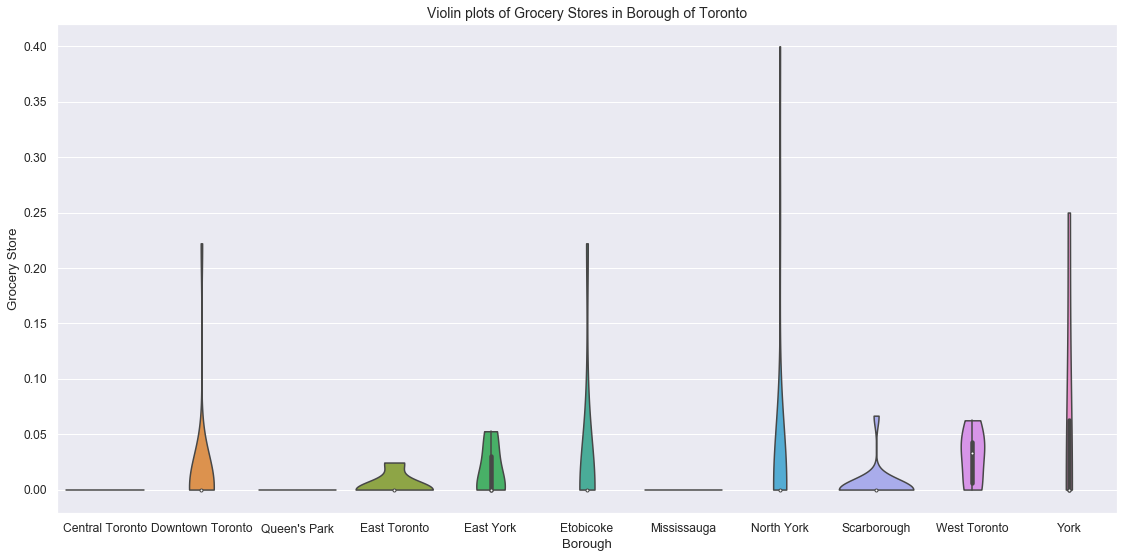

In [28]:
# Let's try Categorical plot 

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Grocery Store", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Grocery Stores in Borough of Toronto', fontsize=14)
plt.show()


This plot helps in identifying the boroughs with grocery shops.

Lets visualize the neighborhood with grocery shops

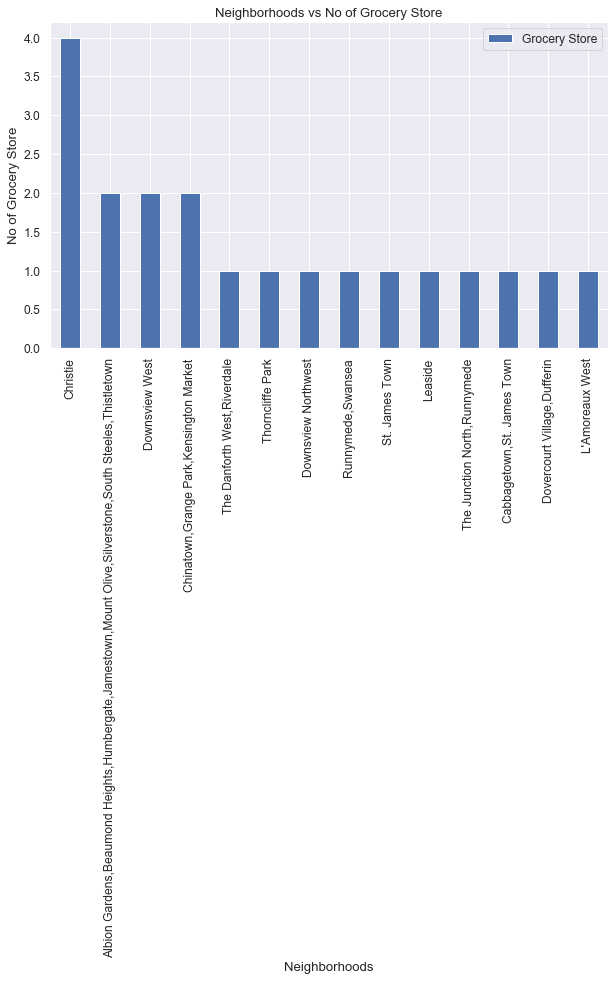

In [29]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Grocery Store'].sum())
graph = graph.sort_values(by ='Grocery Store', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Grocery Store")
plt.title("Neighborhoods vs No of Grocery Store")
plt.show()

## 3.3 Relationship between neighborhood and popultion

In [30]:

#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population']]
pop_ethnic_df

,Riding,Population
0,Willowdale,117405
1,Eglinton-Lawrence,112925
2,Don Valley North,109060
3,Humber River-Black Creek,107725
4,York Centre,103760
5,Don Valley West,101790
6,Don Valley East,93170
7,Scarborough Centre,110450
8,Scarborough Southwest,108295
9,Scarborough-Agincourt,104225


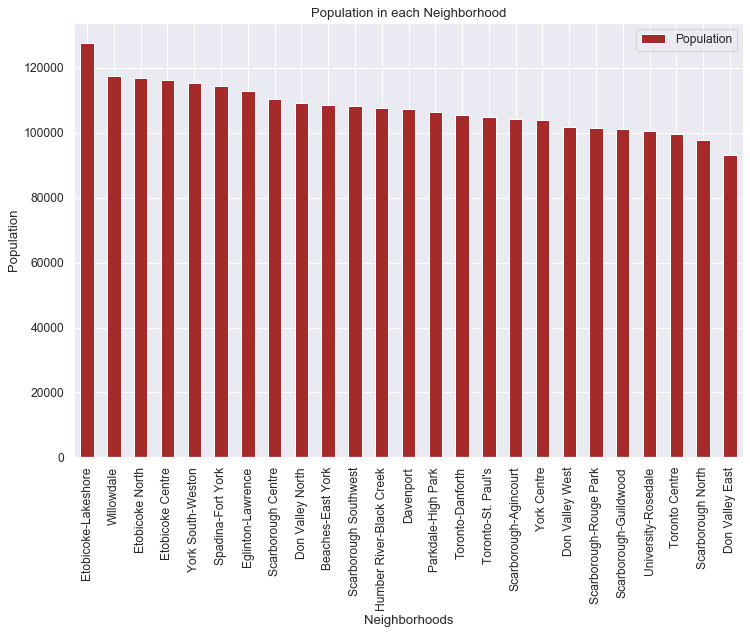

In [31]:
bar_graph = pop_ethnic_df.sort_values(by='Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Population',figsize=(12,8), color='brown')
plt.title("Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

This analysis & visualization of the relationship between neighborhoods & neighbourhood population present in those neighborhoods helps us in identifying the highly populated neighborhoods. Once we identify those neighborhoods it helps us in deciding where to place the new Grocery Store. Grocery Store placed in an densely populated neighborhood is more likely to get more customers than a store placed in a neighborhood with less or no population. Thus this analysis helps in the determining the success of the new Grocery Store.

## 3.4 Relationship between neighbourhood poplation and Grocery store

First get the list of neighborhoods present in the riding using the wikipedia geography section for each riding. Altering the riding names to match the wikipedia page so we can retrieve the neighborhoods present in those ridings

In [32]:

#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_ethnic_df['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list[riding_list.index('Willowdale')] = 'Willowdale (electoral district)'
riding_list[riding_list.index('Davenport')] = 'Davenport (electoral district)'
riding_list[riding_list.index('Etobicoke Centre')] = 'Etobicoke Centre (electoral district)'



riding_list

['Willowdale (electoral district)',
 'Eglinton-Lawrence',
 'Don Valley North',
 'Humber River-Black Creek',
 'York Centre',
 'Don Valley West',
 'Don Valley East',
 'Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Rouge Park',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Etobicoke-Lakeshore',
 'Etobicoke North',
 'Etobicoke Centre (electoral district)',
 'York South-Weston',
 'Spadina-Fort York',
 'Beaches-East York',
 'Davenport (electoral district)',
 'Parkdale-High Park',
 'Toronto-Danforth',
 "Toronto-St. Paul's",
 'University-Rosedale',
 'Toronto Centre']

In [33]:
#Scraping wiki page to get the neighborhoods of each Ridings
import wikipedia

Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    try:
        section = wikipedia.WikipediaPage(item).section('Geography')
        start = section.index('neighbourhoods of') + 17
        stop = section.index('.',start)
        Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    except:
        print(item)
        Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':'Not Available'},ignore_index=True)

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]


Eglinton-Lawrence
Etobicoke-Lakeshore
York South-Weston
Spadina-Fort York
Toronto-Danforth
Toronto-St. Paul's
Toronto Centre


In [34]:
#Merging the pop_indian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_ethnic_df, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop

,Population,Neighborhoods
0,112925,Not Available
1,109060,"Henry Farm, Bayview Village, Bayview Woods-St..."
2,107725,"Humber Summit, Humbermede, Humberlea, York Un..."
3,103760,"Westminster–Branson, Bathurst Manor, Wilson H..."
4,101790,"York Mills, Silver Hills, the western half of..."
5,93170,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
6,108295,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
7,104225,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
8,101445,"Morningside Heights, Rouge, Port Union, West ..."
9,101115,"Guildwood, West Hill (west of Morningside Ave..."


In [35]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop['Neighborhood']=Neigh_pop['Neighborhood'].str.strip()

Neigh_pop

,Population,Neighborhood
0,112925,Not Available
1,109060,Henry Farm
2,107725,Humber Summit
3,103760,Westminster–Branson
4,101790,York Mills
...,...,...
101,109060,and Pleasant View
103,103760,east of Black Creek)
104,101790,and Thorncliffe Park in the City of Toronto–mo...
106,108295,Cliffcrest and parts of Scarborough Village an...


In [36]:

toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Grocery Store'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

C:\Users\indpal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\indpal\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Grocery Store,Neighborhood
0,0.000000,Adelaide
1,0.000000,Agincourt
2,0.000000,Agincourt North
3,0.222222,Albion Gardens
4,0.000000,Alderwood
...,...,...
597,0.222222,South Steeles
608,0.000000,South Niagara
650,0.000000,Royal York South East
696,0.222222,Thistletown


In [38]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent.sort_values(["Population"], axis=0, 
                 ascending=False, inplace=True)
pop_merged_restaurant_percent

,Population,Neighborhood,Grocery Store
22,116960,Thistletown,0.222222
17,116960,Kingsview Village,0.000000
0,109060,Henry Farm,0.000000
7,109060,Bayview Village,0.000000
18,109060,Hillcrest Village,0.000000
24,108295,Clairlea,0.000000
4,108295,Birch Cliff,0.000000
20,108295,Kennedy Park,0.000000
10,108295,Oakridge,0.000000
14,108295,Cliffside,0.000000


After performing the data cleaning & data analysis we can identify that their no big relationship established in terms of the population & the grocery store.

Thus this marks end of the data cleaning & analyses step in this project. Next we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand.

# 4. Predictive Modeling

## 4.1 Clustering Neighborhoods of Toronto:

First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset with grocery store percentage (i.e. toronto_merged dataframe).

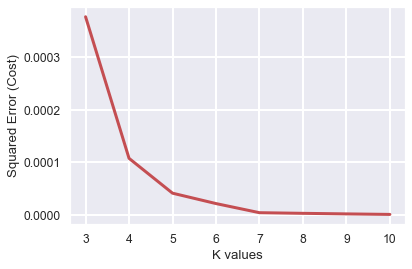

In [39]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [40]:
#!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer

C:\Users\indpal\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


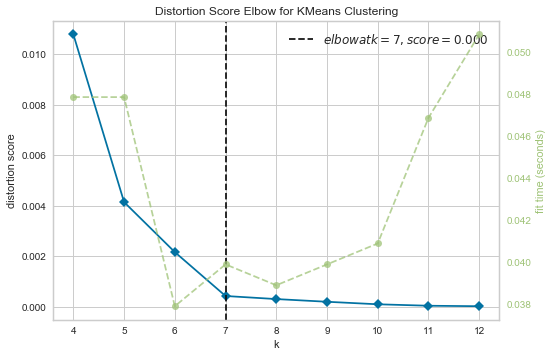

In [41]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(toronto_part_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


<b><i>After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 7 is the best value.</b></i>

<b>Clustering the Toronto Neighborhood Using K-Means with K = 7 </b>

In [42]:
kclusters = 7

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([1, 1, 1, 5, 1, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 1, 1, 4, 5,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       2, 1, 6, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 5, 1, 6, 6, 1, 1, 6, 1, 1,
       4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       6, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 2, 1, 1,
       1, 1, 5, 6, 1, 6, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 0, 5, 1, 1, 1, 1, 0, 5,
       1, 1, 5, 1, 1, 5, 1])

In [47]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
#toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
#toronto_merged = toronto_DF
toronto_merged=pd.read_csv('toronto_neighborhood_latlang_capstone.csv')
toronto_merged = toronto_merged.rename(columns={'Neighbourhood': 'Neighborhood'})
toronto_merged = toronto_merged.rename(columns={'Neighbourhood': 'Latitude'})
toronto_merged = toronto_merged.rename(columns={'Neighbourhood': 'Longitude'})
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
0,M3A,North York,Parkwoods,43.758800,-79.320197,"Parkwoods Village Drive, Parkway East, Don Val...",1.0,0.0
1,M4A,North York,Victoria Village,43.732658,-79.311189,"Victoria Village, Don Valley East, North York,...",1.0,0.0
2,M5A,Downtown Toronto,Harbourfront,43.638834,-79.381878,google,1.0,0.0
3,M6A,North York,Lawrence Heights,43.722778,-79.450933,"Lawrence Heights, Eglinton—Lawrence, North Yor...",1.0,0.0
4,M6A,North York,Lawrence Manor,43.722079,-79.437507,"Lawrence Manor, Eglinton—Lawrence, North York,...",1.0,0.0


Let us see the clusters visually on the map with the help of Folium.



In [48]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]


,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
51,M6H,West Toronto,Dovercourt Village,43.665307,-79.432636,"Dovercourt, Davenport, Old Toronto, Toronto, G...",0.0,0.062500
52,M6H,West Toronto,Dufferin,43.660202,-79.435719,"Dufferin, Dufferin Street, Dovercourt, Davenpo...",0.0,0.062500
180,M1W,Scarborough,L'Amoreaux West,43.799003,-79.305967,"L'Amoreaux, Scarborough—Agincourt, Scarborough...",0.0,0.066667
204,M8Z,Etobicoke,Kingsway Park South West,43.652674,-79.507194,google,0.0,0.071429
205,M8Z,Etobicoke,Mimico NW,43.616677,-79.496805,"Mimico, Windsor Street, Mimico Village, Etobic...",0.0,0.071429
206,M8Z,Etobicoke,The Queensway West,43.633327,-79.475851,"The Queensway, Bloor West Village, Parkdale—Hi...",0.0,0.071429
207,M8Z,Etobicoke,Royal York South West,43.648183,-79.511296,"Royal York, Royal York Road, The Kingsway, Eto...",0.0,0.071429
208,M8Z,Etobicoke,South of Bloor,43.634817,-79.562578,"Westmall Bloor Plaza, Etobicoke, Etobicoke Cen...",0.0,0.071429


In [56]:
#Cluster 1
df_noGrocery=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
df_noGrocery

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
0,M3A,North York,Parkwoods,43.758800,-79.320197,"Parkwoods Village Drive, Parkway East, Don Val...",1.0,0.0
1,M4A,North York,Victoria Village,43.732658,-79.311189,"Victoria Village, Don Valley East, North York,...",1.0,0.0
2,M5A,Downtown Toronto,Harbourfront,43.638834,-79.381878,google,1.0,0.0
3,M6A,North York,Lawrence Heights,43.722778,-79.450933,"Lawrence Heights, Eglinton—Lawrence, North Yor...",1.0,0.0
4,M6A,North York,Lawrence Manor,43.722079,-79.437507,"Lawrence Manor, Eglinton—Lawrence, North York,...",1.0,0.0
...,...,...,...,...,...,...,...,...
199,M8Y,Etobicoke,Mimico NE,43.616677,-79.496805,"Mimico, Windsor Street, Mimico Village, Etobic...",1.0,0.0
200,M8Y,Etobicoke,Old Mill South,43.649826,-79.494334,"Old Mill, Bloor Street West, Old Mill, Etobico...",1.0,0.0
201,M8Y,Etobicoke,The Queensway East,43.609309,-79.567732,"Queensway East, Etobicoke—Lakeshore, Etobicoke...",1.0,0.0
202,M8Y,Etobicoke,Royal York South East,43.648183,-79.511296,"Royal York, Royal York Road, The Kingsway, Eto...",1.0,0.0


In [51]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
108,M3N,North York,Downsview Northwest,43.749299,-79.462248,"Sheppard West, Sheppard West Bus Terminal, Yor...",2.0,0.25
111,M6N,York,The Junction North,43.669438,-79.469121,"West Toronto Street, Little Malta, The Junctio...",2.0,0.25
113,M6N,York,Runnymede,43.665580,-79.482108,"Runnymede, Parkdale—High Park, Old Toronto, To...",2.0,0.25
143,M6S,West Toronto,Runnymede,43.651703,-79.475998,"Runnymede, Runnymede Road, High Park North, Pa...",2.0,0.25


In [52]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
83,M3L,North York,Downsview West,43.749299,-79.462248,"Sheppard West, Sheppard West Bus Terminal, Yor...",3.0,0.4


In [53]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
26,M5C,Downtown Toronto,St. James Town,43.670867,-79.373306,google,4.0,0.023810
39,M4G,East York,Leaside,43.704798,-79.368090,"Leaside, Don Valley West, East York, Toronto, ...",4.0,0.030303
71,M4K,East Toronto,The Danforth West,43.686433,-79.300356,"Danforth, 213, Main Street, Danforth East, Bea...",4.0,0.024390
72,M4K,East Toronto,Riverdale,43.665470,-79.352594,"Riverdale, East York, Toronto—Danforth, Old To...",4.0,0.024390
107,M2N,North York,Willowdale South,43.761509,-79.410923,"Willowdale, North York, Toronto, Golden Horses...",4.0,0.029412
112,M6N,York,Runnymede,43.665580,-79.482108,"Runnymede, Parkdale—High Park, Old Toronto, To...",4.0,0.025000
142,M6S,West Toronto,Runnymede,43.651703,-79.475998,"Runnymede, Runnymede Road, High Park North, Pa...",4.0,0.025000
144,M6S,West Toronto,Swansea,43.644940,-79.478313,"Swansea, Parkdale—High Park, Old Toronto, Toro...",4.0,0.025000
150,M5T,Downtown Toronto,Chinatown,43.650883,-79.397226,google,4.0,0.022989
151,M5T,Downtown Toronto,Grange Park,43.653734,-79.393012,google,4.0,0.022989


In [54]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
41,M6G,Downtown Toronto,Christie,43.662778,-79.422778,google,5.0,0.222222
172,M9V,Etobicoke,Albion Gardens,43.741196,-79.583497,"JVS Toronto, 1530, Albion Road, Beaumonde Heig...",5.0,0.222222
173,M9V,Etobicoke,Beaumond Heights,43.734274,-79.566214,google,5.0,0.222222
174,M9V,Etobicoke,Humbergate,43.628584,-79.491019,"Toronto West Medical, 523, The Queensway, Humb...",5.0,0.222222
175,M9V,Etobicoke,Jamestown,43.671459,-79.552492,"Etobicoke, Toronto, Golden Horseshoe, Ontario,...",5.0,0.222222
176,M9V,Etobicoke,Mount Olive,43.671459,-79.552492,"Etobicoke, Toronto, Golden Horseshoe, Ontario,...",5.0,0.222222
177,M9V,Etobicoke,Silverstone,43.749751,-79.599116,"Silverstone Estates, Etobicoke North, Etobicok...",5.0,0.222222
178,M9V,Etobicoke,South Steeles,43.762059,-79.580221,"Steeles Avenue West, Etobicoke North, Etobicok...",5.0,0.222222
179,M9V,Etobicoke,Thistletown,43.737266,-79.565317,"Thistletown, Etobicoke North, Etobicoke, Toron...",5.0,0.222222


In [55]:
#Cluster 6
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Address,Cluster Labels,Grocery Store
44,M3H,North York,Bathurst Manor,43.763893,-79.456367,"Former Bathurst Manor Plaza grounds, York Cent...",6.0,0.047619
45,M3H,North York,Downsview North,43.749299,-79.462248,"Sheppard West, Sheppard West Bus Terminal, Yor...",6.0,0.047619
46,M3H,North York,Wilson Heights,43.740519,-79.440017,"Wilson Heights, York Centre, North York, Toron...",6.0,0.047619
47,M4H,East York,Thorncliffe Park,43.704553,-79.345407,"Thorncliffe Park, Don Valley West, East York, ...",6.0,0.052632
75,M6K,West Toronto,Brockton,43.650917,-79.440022,"Brockton, Davenport, Old Toronto, Toronto, Gol...",6.0,0.043478
76,M6K,West Toronto,Exhibition Place,43.633469,-79.417865,"Exhibition Place, Spadina—Fort York, Old Toron...",6.0,0.043478
77,M6K,West Toronto,Parkdale Village,43.640495,-79.436897,"Parkdale, Parkdale—High Park, Old Toronto, Tor...",6.0,0.043478
97,M5M,North York,Bedford Park,43.737388,-79.410925,"Bedford Park, Eglinton—Lawrence, North York, T...",6.0,0.040000
98,M5M,North York,Lawrence Manor East,43.722079,-79.437507,"Lawrence Manor, Eglinton—Lawrence, North York,...",6.0,0.040000
121,M6P,West Toronto,High Park,43.653867,-79.466864,"High Park, High Park Bus Platform, High Park N...",6.0,0.041667


In [68]:
nogross=pd.unique(df_noGrocery['Borough'])
print(nogross)

['Etobicoke' 'North York' 'Scarborough' 'Downtown Toronto' 'East York'
 'York' 'East Toronto' 'West Toronto' 'Central Toronto' 'Mississauga']


# 5. Results and Discussion:

## 5.1 Results

We have reached the end of the analysis, in the result section we can document all the findinds from above clustering & visualization of the datas. In this project, as the business problem started with identifying a good neighborhood to open a new grocery store, we looked into all the neighborhoods in Toronto, analysed the population in each neighborhood & spread of grocery stores in those neighborhoods to come to conclusion about which neighborhood would be a better spot for opening a new grocery store. I have used data from web resources like Wikipedia, geospatial coordinates of Toronto neighborhoods, and Foursquare API, to set up a very realistic data-analysis scenario. We have found out that —

In those 11 boroughs we identified that only downtown toronto,East Toronto,East York,Etobicoke Borough,North York,Scarborough,West Toronto boroughs have high amount of grocery stores with the help of Violin plots between Number of Grocery stores in Borough of Toronto.

With the help of clusters examing & violin plots looks like all the above mentioned boroughs are having grocery stores within it. So it is better idea to leave those boroughs out and consider only York & Mississauga for the new grocery store's location.

After careful consideration it is a good idea to open a new grocery store in York borough since it has high number of population which gives a higher number of customers possibility and lower competition.

## 5.2 Discussion

According to this analysis, York borough will provide least competition for the new upcoming grocery store as there is very little grocery store spread or no stores in neighborhoods. Also looking at the population distribution looks like it is densely populated  which helps the new store by providing huge customer visit possibilty. So, definitely this region could potentially be a perfect place for starting a quality grocery store. Some of the drawbacks of this analysis are — the clustering is completely based only on data obtained from Foursquare API. Also the population distribution in each neighborhood is also based on the 2016 census which is not up-to date. Thus population distribution would have definitely changed by 2019 given 3 years gap in the data. Since population distribution of crowd in each neighborhood & number of grocery stores are the major feature in this analysis and it is not fully up-to date data, this analysis is definitely not far from being conclusory & it has lot of areas where it can be imporved. However, it certainly provides us with some good insights, preliminary information on possibilites & a head start into this business problem by setting the step stones properly. Furthermore, this may also potentially vary depending on the type of clustering techniques that we use to examine the data.

# 6. Conclusion:

Finally to conclude this project, We have got a chance to on a business problem like how a real like data scientists would do. We have used many python libraries to fetch the data , to manipulate the contents & to analyze and visualize those datasets. We have made use of Foursquare API to explore the venues in enighborhoods of Toronto, then get good amount of data from Wikipedia which we scraped with help of Wikipedia python library and visualized using various plots present in seaborn & matplotlib. We also applied machine learning technique to to predict the output given the data and used Folium to visualize it on a map. Also, some of the drawbacks or areas of improvements shows us that this analysis can further be improved with help more data and different machine learning technique. Similarly we can use this project to analysis any scenario such opening a different cuisine or success of opening a new gym and etc. Hopefully, this project helps acts as initial guidance to take more complex real-life challenges using data-science.